## Problem 1
From the conditions given in the problem, the prediction of the pressue can be calculated as follows: 
$$
\begin{aligned}
p_{estimate} = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

The actual pressure $p$ is given in the problem, the least square function can be written as,
$$
\begin{aligned}
\min_{A12, A21} && \sum_{k=1}^{11}(p_{estimate} - p)^2 \\
\end{aligned}
$$

A12 and A21 estimated values are: tensor([1.9103, 1.7298], requires_grad=True)
Loss is: 0.87948006


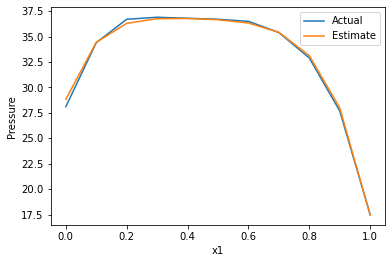

In [30]:
import matplotlib.pyplot as mplt
import numpy as np
import torch
from torch.autograd import Variable
from IPython import display

X1 = np.array([[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
X2 = 1-X1 #Since, X1+X2=1
a = np.array(([[8.07131, 1730.63, 233.426], [7.43155, 1554.679, 240.337]]))
T = 20
p_water = 10 ** (a[0, 0] - a[0, 1] / (T + a[0, 2]))
p_dio = 10 ** (a[1, 0] - a[1, 1] / (T + a[1, 2]))
P = np.array([[28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]])
P = torch.tensor(P, requires_grad=False, dtype=torch.float32)

A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True)

x1 = torch.tensor(X1, requires_grad=False, dtype=torch.float32)
x2 = torch.tensor(X2, requires_grad=False, dtype=torch.float32)

dx = 0.00001

for i in range(1000):
    P_est = x1 * torch.exp(A[0] * (A[1] * x2 / (A[0] * x1 + A[1] * x2)) ** 2) * p_water + \
        x2 * torch.exp(A[1] * (A[0] * x1 / (A[0] * x1 + A[1] * x2)) ** 2) * p_dio

    loss = (P_est - P) ** 2
    loss = loss.sum()

    loss.backward()

    with torch.no_grad():
        A -= dx * A.grad

        A.grad.zero_()

print('A12 and A21 estimated values are:',A)
print('Loss is:',loss.data.numpy())

P_est = P_est.detach().numpy()[0]
P = P.detach().numpy()[0]
x1 = x1.detach().numpy()[0]

mplt.plot(x1, P, label='Actual')
mplt.plot(x1, P_hat, label='Estimate')
mplt.xlabel('x1')
mplt.ylabel('Pressure')
mplt.legend()

## Problem 2

minimum value for objective function is : -0.6740373938198434
x1, x2 when having minumum objective function: [-0.41215344  0.74650392]


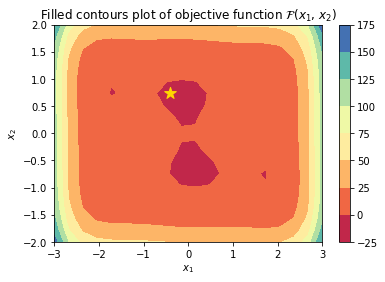

In [37]:
import matplotlib.pyplot as mplt
import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
            # print()
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp
def sample_loss(params):
    return (4 - 2.1 * params[0] ** 2 + params[0] ** 4 / 3) * params[0] ** 2 + params[0] * params[1] + (-4 + 4 * params[1] ** 2) * params[1] ** 2

bounds = np.array([[-3, 3], [-2, 2]])

xp, yp = bayesian_optimisation(n_iters=30,
                               sample_loss=sample_loss,
                               bounds=bounds,
                               n_pre_samples=20,
                               random_search=100000)

print('minimum value for objective function is :', np.min(yp))
print('x1, x2 when having minumum objective function:',xp[np.argmin(yp)])


X1 = np.linspace(-3, 3, 20)
X2 = np.linspace(-2, 2, 20)

param_grid = np.array([[x1, x2] for x2 in X2 for x1 in X1])
real_loss = [sample_loss(params) for params in param_grid]

C, G = np.meshgrid(X1, X2)
result = np.array(real_loss).reshape(C.shape)
mplt.figure()
cp = mplt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap=mplt.cm.Spectral)
mplt.colorbar(cp)
mplt.scatter(xp[np.argmin(yp)][0], xp[np.argmin(yp)][1], marker='*', c='gold', s=150)
mplt.title('Filled contours plot of objective function $\mathcal{F}$($x_{1}$, $x_{2}$)')
mplt.xlabel('$x_{1}$')
mplt.ylabel('$x_{2}$')
mplt.show()